In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from gensim.models import Word2Vec
import torch
import datetime

import sys
# sys.path.append("..")
# from lib.metrics import evaluate

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

DATA_PATH="../data/sz_taxi_202006/"
vec_size=512

%pwd

'/home/cseadmin/dz/TrafficFlowModel/model/deprecated'

In [2]:
traj_list=np.load("../../data/sz_taxi_202006/sz_taxi_202006_traj_list.npy", allow_pickle=True)

len(traj_list)
traj_list[0]

AttributeError: Can't get attribute '_unpickle_timestamp' on <module 'pandas._libs.tslibs.timestamps' from '/home/cseadmin/dz/anaconda3/envs/torch1.7/lib/python3.7/site-packages/pandas/_libs/tslibs/timestamps.cpython-37m-x86_64-linux-gnu.so'>

(array([4.82609e+05, 3.98275e+05, 2.63966e+05, 1.95140e+05, 1.35211e+05,
        9.08700e+04, 6.93990e+04, 3.69020e+04, 2.44290e+04, 1.67950e+04,
        1.13810e+04, 7.73800e+03, 6.29200e+03, 3.59500e+03, 2.53400e+03,
        1.90000e+03, 1.25200e+03, 9.19000e+02, 7.99000e+02, 4.25000e+02,
        3.01000e+02, 2.22000e+02, 1.82000e+02, 1.20000e+02, 9.10000e+01,
        8.50000e+01, 4.40000e+01, 3.30000e+01, 2.40000e+01, 1.90000e+01,
        1.00000e+01, 1.30000e+01, 6.00000e+00, 6.00000e+00, 4.00000e+00,
        1.00000e+00, 0.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00,
        2.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  1.  ,   6.16,  11.32,  16.48,  21.64,  26.8 ,  31.96,  37.12,
         42.28,  47.44,  52.6 ,  57.76,  62.92,  68.08,  73.24,  78.4 ,
         83.56,  88.72,  93.88,  99.04, 104.2 , 109.36, 114.52, 119.68,
        124.84, 130.  , 135.16, 140.32, 145.48, 150.

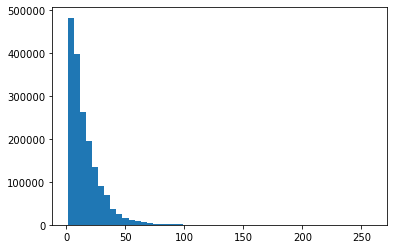

In [8]:
n=5
len_list=[]
count=0
for traj in traj_list:
    len_list.append(len(traj))
    
len_list=np.array(len_list)
plt.hist(len_list, bins=50)
plt.show()

In [10]:
all_tracks=[]
for traj in traj_list:
    road_ids=[]
    for point in traj:
        road_ids.append(point[0])
    all_tracks.append(road_ids)

len(all_tracks)
all_tracks[0]

1751602

[198, 199, 448]

In [13]:
w2v_all_traj=Word2Vec(all_tracks, sg=1, hs=1, vector_size=vec_size, window=10, min_count=1, workers=4)

w2v_all_traj.save(os.path.join(DATA_PATH, f"w2v_all_traj_{vec_size}.model"))

model

---

In [3]:
w2v_all_traj=Word2Vec.load(os.path.join(DATA_PATH, f"w2v_all_traj_{vec_size}.model"))
wv=w2v_all_traj.wv

wv.distance(0, 3)

0.7991076111793518

In [4]:
index=np.argsort(wv.index_to_key)
embed_vectors=wv.get_normed_vectors()

embed_vectors=embed_vectors[index]
embed_vectors[0][:10]

array([-0.04961416,  0.03711881,  0.00701622, -0.02471929,  0.04195437,
        0.05551275, -0.0024164 ,  0.03509161, -0.01095492,  0.05997162],
      dtype=float32)

In [7]:
correlation_matrix = embed_vectors @ embed_vectors.T

correlation_matrix.shape
correlation_matrix[0][:10]

(492, 492)

array([1.0000002 , 0.13911077, 0.18122032, 0.20089237, 0.2514562 ,
       0.16970405, 0.21216552, 0.12217825, 0.12732378, 0.13965628],
      dtype=float32)

In [68]:
from torch.nn.parameter import Parameter
import math

class GraphConvolution(torch.nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    
    out = A*X*W
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        print("inp-", input.shape)
        support = torch.matmul(input, self.weight) # (bs, N, hidden_dim)
        print("sup-", support.shape)
        support=support.permute(1, 2, 0)
        print("sup-", support.shape)
        output = torch.matmul(adj, support).permute(2, 0, 1)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class DontKnowWhat2EatNN(torch.nn.Module):
    def __init__(self, graph_embed_vectors, in_step, out_step, num_heads=8, drop_rate=0):
        super(DontKnowWhat2EatNN, self).__init__()
        
        self.graph_embed_vectors=torch.FloatTensor(graph_embed_vectors.reshape(graph_embed_vectors.shape[0], 1, graph_embed_vectors.shape[1]))
        self.embed_dim=graph_embed_vectors.shape[-1]
        self.num_heads=num_heads
        self.drop_rate=drop_rate
        
        self.mh_attention=torch.nn.MultiheadAttention(self.embed_dim, self.num_heads, dropout=self.drop_rate)
        self.gcn1=GraphConvolution(in_step, 64)
        self.bn1=torch.nn.BatchNorm2d(64)
        self.gcn2=GraphConvolution(64, 64)
        self.bn2=torch.nn.BatchNorm2d(64)
        self.fc=torch.nn.Linear(64, out_step)
        
        
    def forward(self, x):
        """
        x: (batch_size, N, in_step, num_features)
        """
        
        attn_output, attn_output_weights=self.mh_attention.forward(self.graph_embed_vectors, self.graph_embed_vectors, self.graph_embed_vectors)
        attn_output=attn_output.reshape(attn_output.shape[0], attn_output.shape[2])
        correlation_matrix=attn_output @ attn_output.T
        
        print("x-", x.shape)
        out=self.gcn1(x, correlation_matrix)
        out=self.bn1(out)
        out=self.gcn2(out, correlation_matrix)
        out=self.bn2(out)
        # out=out.reshape(out.shape[0], out.shape[1], -1)
        out=self.fc(out)
        
        return out
    

In [21]:
a=torch.Tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]], [[9, 10], [11, 12]]])
b=torch.Tensor([[0.5, 0.5], [0.5, 0.5]])

a
b

tensor([[[ 1.,  2.],
         [ 3.,  4.]],

        [[ 5.,  6.],
         [ 7.,  8.]],

        [[ 9., 10.],
         [11., 12.]]])

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]])

In [43]:
torch.matmul(a, b)
torch.matmul(b, a.permute(1, 2, 0)).permute(2, 0, 1)

tensor([[[ 1.5000,  1.5000],
         [ 3.5000,  3.5000]],

        [[ 5.5000,  5.5000],
         [ 7.5000,  7.5000]],

        [[ 9.5000,  9.5000],
         [11.5000, 11.5000]]])

tensor([[[ 1.,  5.,  9.],
         [ 2.,  6., 10.]],

        [[ 3.,  7., 11.],
         [ 4.,  8., 12.]]])

tensor([[[ 1.5000,  1.5000],
         [ 3.5000,  3.5000]],

        [[ 5.5000,  5.5000],
         [ 7.5000,  7.5000]],

        [[ 9.5000,  9.5000],
         [11.5000, 11.5000]]])

train

---

In [59]:
def gen_xy(data, in_steps, out_steps):
    """
    Parameter
    ---
    data: (N, timesteps)
    
    Returns
    ---
    x: (num_samples, N, in_steps, num_features=1) Tensor
    y: (num_samples, N, out_steps, num_features=1) Tensor
        num_samples is determined by `timesteps` and `in_steps+out_steps`
    """
    # Generate the beginning index and the ending index of a sample, which
    # contains (num_points_for_training + num_points_for_predicting) points
    all_steps=data.shape[1]
    indices = [(i, i + (in_steps + out_steps)) for i in range(all_steps - (in_steps + out_steps) + 1)]
    
    x, y=[], []
    for begin, end in indices:
        x.append(data[:, begin: begin+in_steps])
        y.append(data[:, begin+in_steps: end])
        
    x=np.array(x)
    y=np.array(y)
    
    # if x.ndim==3 and y.ndim==3:
    #     x=x[:, :, :, np.newaxis]
    #     y=y[:, :, :, np.newaxis]
        
    return torch.Tensor(x), torch.Tensor(y)

def read_data(data_path, file_type="pickle", transpose=False):
    """
    Returns
    ---
    X: (N, all_timesteps) numpy
    """
    if file_type=="pickle":
        data=pd.read_pickle(data_path)
    elif file_type=="csv":
        data=pd.read_csv(data_path)
    else:
        print("Invalid file type.")
        sys.exit(1)
        
    data=data.values.astype(np.float)
    if transpose:
        data=data.T
    print("Original data shape", data.shape)
    return data

def get_dataloaders(data, in_steps, out_steps, train_size=0.7, val_size=0.1, batch_size=32):
    """
    Parameters
    ---
    data: (N, all_timesteps) numpy
    """
    all_steps=data.shape[1]
    split1=int(all_steps*train_size)
    split2=int(all_steps*(train_size+val_size))
    
    train_data=data[:, :split1]
    val_data=data[:, split1:split2]
    test_data=data[:, split2:]
    
    x_train, y_train=gen_xy(train_data, in_steps, out_steps)
    x_val, y_val=gen_xy(val_data, in_steps, out_steps)
    x_test, y_test=gen_xy(test_data, in_steps, out_steps)
    
    print(f"Trainset:\tx-{x_train.size()}\ty-{y_train.size()}")
    print(f"Valset:  \tx-{x_val.size()}  \ty-{y_val.size()}")
    print(f"Testset:\tx-{x_test.size()}\ty-{y_test.size()}")
    
    trainset=torch.utils.data.TensorDataset(x_train, y_train)
    valset=torch.utils.data.TensorDataset(x_val, y_val)
    testset=torch.utils.data.TensorDataset(x_test, y_test)
    
    trainset_loader=torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valset_loader=torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
    testset_loader=torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    return trainset_loader, valset_loader, testset_loader

In [60]:
def train_one_epoch(model, trainset_loader, optimizer, criterion, gpu=True):
    model.train()
    batch_loss_list=[]
    for x_batch, y_batch in trainset_loader:
        if gpu and torch.cuda.is_available():
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

        out_batch = model.forward(x_batch)
        loss = criterion.forward(out_batch, y_batch)
        batch_loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return sum(batch_loss_list)/len(batch_loss_list)

@torch.no_grad()
def eval_model(model, valset_loader, criterion, gpu=True):
    model.eval()
    batch_loss_list=[]
    for x_batch, y_batch in valset_loader:
        if gpu and torch.cuda.is_available():
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

        out_batch = model.forward(x_batch)
        loss = criterion.forward(out_batch, y_batch)
        batch_loss_list.append(loss.item())

    return sum(batch_loss_list)/len(batch_loss_list)

def train(model, trainset_loader, valset_loader, optimizer, criterion, max_epochs=100, early_stop=10, verbose=1, gpu=True, plot=False):
    wait=0
    min_val_loss=np.inf
    
    train_loss_list=[]
    val_loss_list=[]
    
    for epoch in range(max_epochs):
        train_loss=train_one_epoch(model, trainset_loader, optimizer, criterion, gpu)
        train_loss_list.append(train_loss)
        
        val_loss=eval_model(model, valset_loader, criterion)
        val_loss_list.append(val_loss)
        
        if (epoch+1)%verbose==0:
            print(datetime.datetime.now(), "Epoch", epoch,
                  "\tTrain Loss = %.5f"%train_loss,
                  "\tVal Loss = %.5f"%val_loss)
        
        if val_loss<min_val_loss:
            wait=0
            min_val_loss=val_loss
            best_epoch=epoch
        else:
            wait+=1
            if wait >= early_stop:
                print("Early stopping at epoch: %d" % epoch)
                break
        
    if plot:
        plt.plot(range(0, epoch+1), train_loss_list, "-", label="Train Loss")
        plt.plot(range(0, epoch+1), val_loss_list, "-", label="Val Loss")
        plt.title("Epoch-Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

In [69]:
data=read_data("../data/sz_taxi_202006/sz_taxi_202006_5min_recovered_flow_dlt.pkl", transpose=True)
train_loader, val_loader, test_loader=get_dataloaders(data, 12, 12)
model=DontKnowWhat2EatNN(embed_vectors, 12, 12)
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, test_loader, criterion, gpu=False)

Original data shape (492, 8064)
Trainset:	x-torch.Size([5621, 492, 12])	y-torch.Size([5621, 492, 12])
Valset:  	x-torch.Size([784, 492, 12])  	y-torch.Size([784, 492, 12])
Testset:	x-torch.Size([1590, 492, 12])	y-torch.Size([1590, 492, 12])
x- torch.Size([32, 492, 12])
inp- torch.Size([32, 492, 12])
sup- torch.Size([32, 492, 64])
sup- torch.Size([492, 64, 32])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (15744x64 and 492x492)